<a href="https://colab.research.google.com/github/sithin42/INT-PROSTATE-Contour-Stability/blob/main/3_StabilityAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

ROOT_PATH = "./"
#Loading the example data from github
if IN_COLAB:
  ROOT_PATH = "./INT-PROSTATE-Contour-Stability"
  !git clone https://github.com/sithin42/INT-PROSTATE-Contour-Stability.git
  import sys
  sys.path.append(ROOT_PATH)
  

fatal: destination path 'INT-PROSTATE-Contour-Stability' already exists and is not an empty directory.


In [34]:
#Requirements 
!pip install pandas
!pip install pingouin
!pip install seaborn


In [35]:
import os
from tqdm import tqdm
import pandas as pd
import pingouin as pg
import seaborn as sns
import numpy as np

from ipywidgets import widgets, interact
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [36]:
AUG_TYPE = "in_plane"
BIAS_TYPE = "random"

# Data IO

In [37]:
OUT_PATH = f"./results"

if not os.path.exists(OUT_PATH):
  OUT_PATH = os.path.join(ROOT_PATH,"results")

In [38]:
org_df = pd.read_csv(os.path.join(OUT_PATH,"org_feats.csv"))
aug_df = pd.read_csv(os.path.join(OUT_PATH,f"{AUG_TYPE}_{BIAS_TYPE}","aug_feats.csv"))

merged_df = pd.concat([org_df,aug_df],ignore_index=True)

merged_df.head()

,Unnamed: 0,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,diagnostics_Image-original_Size,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_Hash,diagnostics_Mask-original_Spacing,diagnostics_Mask-original_Size,diagnostics_Mask-original_BoundingBox,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Mask-original_CenterOfMassIndex,diagnostics_Mask-original_CenterOfMass,diagnostics_Image-interpolated_Spacing,diagnostics_Image-interpolated_Size,diagnostics_Image-interpolated_Mean,diagnostics_Image-interpolated_Minimum,diagnostics_Image-interpolated_Maximum,diagnostics_Mask-interpolated_Spacing,diagnostics_Mask-interpolated_Size,diagnostics_Mask-interpolated_BoundingBox,diagnostics_Mask-interpolated_VoxelNum,diagnostics_Mask-interpolated_VolumeNum,diagnostics_Mask-interpolated_CenterOfMassIndex,diagnostics_Mask-interpolated_CenterOfMass,diagnostics_Mask-interpolated_Mean,diagnostics_Mask-interpolated_Minimum,diagnostics_Mask-interpolated_Maximum,original_shape_Elongation,original_shape_Flatness,...,exponential_glrlm_ShortRunHighGrayLevelEmphasis,exponential_glrlm_ShortRunLowGrayLevelEmphasis,exponential_glszm_GrayLevelNonUniformity,exponential_glszm_GrayLevelNonUniformityNormalized,exponential_glszm_GrayLevelVariance,exponential_glszm_HighGrayLevelZoneEmphasis,exponential_glszm_LargeAreaEmphasis,exponential_glszm_LargeAreaHighGrayLevelEmphasis,exponential_glszm_LargeAreaLowGrayLevelEmphasis,exponential_glszm_LowGrayLevelZoneEmphasis,exponential_glszm_SizeZoneNonUniformity,exponential_glszm_SizeZoneNonUniformityNormalized,exponential_glszm_SmallAreaEmphasis,exponential_glszm_SmallAreaHighGrayLevelEmphasis,exponential_glszm_SmallAreaLowGrayLevelEmphasis,exponential_glszm_ZoneEntropy,exponential_glszm_ZonePercentage,exponential_glszm_ZoneVariance,exponential_ngtdm_Busyness,exponential_ngtdm_Coarseness,exponential_ngtdm_Complexity,exponential_ngtdm_Contrast,exponential_ngtdm_Strength,exponential_gldm_DependenceEntropy,exponential_gldm_DependenceNonUniformity,exponential_gldm_DependenceNonUniformityNormalized,exponential_gldm_DependenceVariance,exponential_gldm_GrayLevelNonUniformity,exponential_gldm_GrayLevelVariance,exponential_gldm_HighGrayLevelEmphasis,exponential_gldm_LargeDependenceEmphasis,exponential_gldm_LargeDependenceHighGrayLevelEmphasis,exponential_gldm_LargeDependenceLowGrayLevelEmphasis,exponential_gldm_LowGrayLevelEmphasis,exponential_gldm_SmallDependenceEmphasis,exponential_gldm_SmallDependenceHighGrayLevelEmphasis,exponential_gldm_SmallDependenceLowGrayLevelEmphasis,id,dice,judge
0,0,v3.0.1,1.19.5,2.1.1,1.1.1,3.7.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [2.0, 3.0, 4...",3113612f2899bbba113384f1747b9b716ad30be8,3D,"(0.3125, 0.3125, 3.0)","(512, 512, 30)",391.272048,0.0,11139.0,58c60672e6a2abd8d3caa3ca421d0f37989a4b73,"(0.3125, 0.3125, 3.0)","(512, 512, 30)","(180, 193, 7, 154, 103, 12)",94679,1,"(253.96146980851086, 247.28200551336622, 13.49...","(1.66226046262058, -12.186775620823056, -10.49...","(0.3, 0.3, 3.3)","(185, 131, 28)",58.454832,-154.803072,1207.870512,"(0.3, 0.3, 3.3)","(185, 131, 28)","(12, 12, 6, 156, 107, 11)",89917,1,"(89.24102227609907, 68.21153953090072, 11.9548...","(1.5653578302906581, -12.305190484479791, -11....",136.385329,-74.360766,823.600007,0.819156,0.723521,...,0.438192,0.167660,3.000000,0.272727,2.082645,10.545455,7.232966e+08,7.233929e+08,7.232736e+08,0.236591,1.181818,0.107438,0.212829,3.783304,0.032447,3.459432,0.000122,6.564779e+08,34.178910,0.002928,0.186449,1.017405e-05,0.141323,1.920327,41446.444643,0.460941,26.014993,88484.738359,0.017696,1

#Compute ICC(1,1)

In [39]:
NON_FEAT_COLS = ["diagnostics","id","judge","Unnamed","dice"]

In [40]:
def compute_icc(df, features):

  out_icc = {"feature":[],"icc_value":[],"ci_down":[],"ci_up":[]}
  pbar = tqdm(range(len(features)),position=0,desc="Computing ICC")

  for feature in features:

      icc = pg.intraclass_corr(data=df,targets='id',raters='judge',ratings=feature)
      
      icc_value = np.round(icc['ICC'][0],2)
      ci_down = np.round(icc['CI95%'][0][0],2)
      ci_up = np.round(icc['CI95%'][0][1],2)

      out_icc["feature"].append(feature)
      out_icc["icc_value"].append(icc_value if icc_value>=0 else 0)
      out_icc["ci_down"].append(ci_down if ci_down>=0 else 0)
      out_icc["ci_up"].append(ci_up if ci_up>=0 else 0)
      pbar.update()


  out_icc = pd.DataFrame.from_dict(out_icc)

  return out_icc


In [41]:
def getICC(df):

    features = list(df.columns.values)

    for column in df.columns:
        for ignore_column in NON_FEAT_COLS:
            if ignore_column in column:
                features.remove(column)
    
    out_icc = compute_icc(df,features)

    return out_icc, features
    


In [42]:
icc_df, features = getICC(merged_df)

icc_df.head()

Computing ICC: 100%|██████████| 1595/1595 [02:07<00:00, 12.53it/s]


,feature,icc_value,ci_down,ci_up
0,original_shape_Elongation,0.62,0.20,1.0
1,original_shape_Flatness,0.98,0.90,1.0
2,original_shape_LeastAxisLength,0.92,0.67,1.0
3,original_shape_MajorAxisLength,0.98,0.92,1.0
4,original_shape_Maximum2DDiameterColumn,0.96,0.81,1.0


#ICC Visualization

In [43]:
STABILITY_THRESHOLD = 0.90

In [47]:
def visualize(icc_df, threshold):

  df = icc_df.copy()
  df["hue"] = [0] * len(df)
  df.loc[df["ci_down"]>=0.9,["hue"]] = 1

  xerr = [df["icc_value"]-df["ci_down"],df["ci_up"]-df["icc_value"]]

  fig = plt.figure(figsize = (3,20))
  ax = fig.gca()

  sns.set_theme(style="whitegrid")
  g = sns.barplot(x="icc_value",y="feature",data=df, ax=ax,color='#2ca25f',hue='hue',dodge=False,xerr=xerr)
  g.legend_.remove()

  plt.margins(0,0)

  plt.savefig(f"./{AUG_TYPE}_{BIAS_TYPE}.png", bbox_inches = 'tight',
      pad_inches = 0,transparent=True,dpi=300)



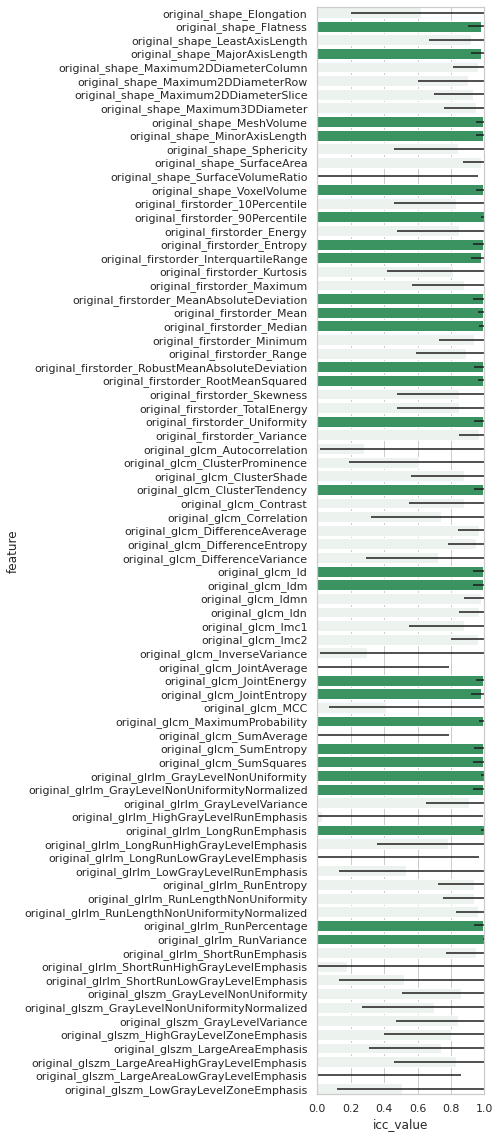

In [48]:
df = icc_df.head(80)
visualize(df,STABILITY_THRESHOLD)